In [1]:
from gerrychain import Graph
import gurobipy as gp
from gurobipy import GRB
import math
from geopy.distance import geodesic
import geopandas as gpd

In [2]:
#Set filepath and filename equal to the path/name of the data used respectively
filepath = 'C:\\Users\\sambo\\OneDrive\\Desktop\\IEM4013 Redistricting Project\\'
filename= 'AR_county.json'

#Create a new Graph object G from the file
G = Graph.from_json(filepath + filename)

#
for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20']
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20']

In [3]:
# create distance dictionary
dist = { (i,j) : 0 for i in G.nodes for j in G.nodes }
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'], G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'], G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles

In [4]:
dev = 0.01


k = 4
tot_pop = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-dev/2)*tot_pop/k)
U = math.floor((1+dev/2)*tot_pop/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 749117 and U = 756645 and k = 4


In [5]:


m = gp.Model()

x = m.addVars(G.nodes, G.nodes, vtype=GRB.BINARY)

Set parameter Username
Set parameter LicenseID to value 2663177
Academic license - for non-commercial use only - expires 2026-05-09


In [6]:
m.setObjective( gp.quicksum( dist[i,j] * dist[i,j] * G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE )

In [7]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )

# add constraint saying there should be k district centers
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

# add constraints that say: if j roots a district, then its population is between L and U.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U * x[j,j] for j in G.nodes )

# add coupling constraints saying that if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [8]:
# add contiguity constraints
import networkx as nx
DG = nx.DiGraph(G)

# add flow variables
#    f[i,j,v] = flow across arc (i,j) that is sent from source/root v
f = m.addVars( DG.edges, G.nodes ) 

# add constraints saying that if node i is assigned to node j, 
#   then node i must consume one unit of node j's flow
m.addConstrs( gp.quicksum( f[u,i,j] - f[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j )

# add constraints saying that node i can receive flow of type j 
#   only if node i is assigned to node j
M = G.number_of_nodes() - 1
m.addConstrs( gp.quicksum( f[u,i,j] for u in G.neighbors(i) ) <= M * x[i,j] for i in G.nodes for j in G.nodes if i != j )

# add constraints saying that node j cannot receive flow of its own type
m.addConstrs( gp.quicksum( f[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes )

m.update()

In [9]:
m.Params.MIPGap = 0.0

m.optimize()

Set parameter MIPGap to value 0
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 7 155H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Non-default parameters:
MIPGap  0

Optimize a model with 17026 rows, 34425 columns and 124782 nonzeros
Model fingerprint: 0x1234a37a
Variable types: 28800 continuous, 5625 integer (5625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [2e+06, 2e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 161 rows and 398 columns
Presolve time: 0.83s
Presolved: 16865 rows, 34027 columns, 123984 nonzeros
Variable types: 28402 continuous, 5625 integer (5625 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


In [10]:
# print the objective value
print(m.objVal)

# retrieve the districts and their populations
#    but first get the district "centers"

centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in centers ]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

6835095216.710739
District 0 has population 753326 and contains counties ['Jackson', 'Clay', 'Baxter', 'St. Francis', 'Sharp', 'Greene', 'Woodruff', 'White', 'Lee', 'Crittenden', 'Marion', 'Prairie', 'Lawrence', 'Poinsett', 'Independence', 'Lonoke', 'Fulton', 'Arkansas', 'Randolph', 'Izard', 'Craighead', 'Cleburne', 'Monroe', 'Mississippi', 'Cross', 'Phillips']

District 1 has population 749461 and contains counties ['Franklin', 'Faulkner', 'Boone', 'Conway', 'Pulaski', 'Madison', 'Pope', 'Stone', 'Van Buren', 'Johnson', 'Searcy', 'Perry']

District 2 has population 755116 and contains counties ['Little River', 'Ashley', 'Desha', 'Montgomery', 'Howard', 'Nevada', 'Grant', 'Dallas', 'Cleveland', 'Lafayette', 'Saline', 'Chicot', 'Bradley', 'Drew', 'Pike', 'Union', 'Hempstead', 'Polk', 'Clark', 'Logan', 'Miller', 'Garland', 'Sevier', 'Jefferson', 'Lincoln', 'Scott', 'Hot Spring', 'Columbia', 'Ouachita', 'Yell', 'Calhoun']

District 3 has population 753621 and contains counties ['Crawford'

In [11]:
filepath = 'C:\\Users\\sambo\\OneDrive\\Desktop\\IEM4013 Redistricting Project\\'
filename = 'AR_county.shp'
df = gpd.read_file( filepath + filename)

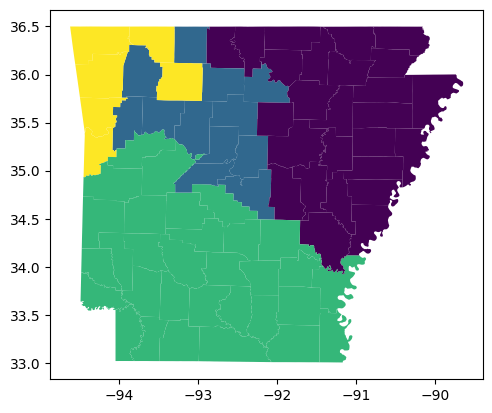

In [12]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()